# Compartment Analysis 

In [68]:
from cooltools.eigdecomp import cis_eig
import cooler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import statistics as st
import pandas as pd

Make matrix

In [7]:
cool = cooler.Cooler('K562_hg19_chr3_50K.cool')
mat = cool.matrix(balance=True)[:]

Make signal track array from GC

In [5]:
GC = open("hg19_GC_chr3_50K.txt","r")
array = []
for line in GC:
    signal_track = line.strip()
    array.append(float(signal_track))
array = np.asarray(array)
array

array([0.     , 0.16752, 0.23058, ..., 0.22148, 0.06538, 0.     ])

Compartment plot

In [10]:
compartment = cis_eig(mat, n_eigs = 1, phasing_track = array)[1][0]
compartment

array([        nan, -0.07931084,  0.08391484, ...,         nan,
               nan,         nan])

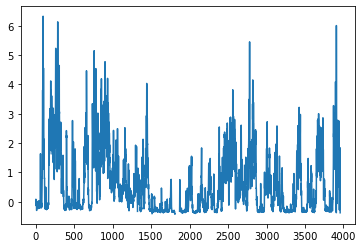

In [12]:
fig, ax = plt.subplots()
ax.plot(range(0,len(compartment)), compartment)
plt.show()

Interaction

<function matplotlib.pyplot.show(close=None, block=None)>

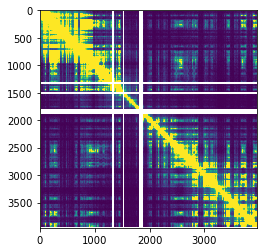

In [13]:
plt.imshow(mat, vmax=1)
plt.show

Make first eigenvector into df

In [30]:
first_eig=pd.DataFrame(compartment, columns = ["First eigenvalue"]) 
first_eig.at[first_eig["First eigenvalue"]>0,"Compartment"] = "A"
first_eig.at[first_eig["First eigenvalue"] <= 0,"Compartment"] = "B"
first_eig

,First eigenvalue,Compartment
0,NaN,NaN
1,-0.079311,B
2,0.083915,A
3,0.020302,A
4,-0.004100,B
...,...,...
3956,0.499733,A
3957,-0.377151,B
3958,NaN,NaN
3959,NaN,NaN


Add chromosome start and end position

In [31]:
cooldata = (cool.bins()[:])
cooldata

,chrom,start,end,KR,VC,VC_SQRT,weight
0,1,0,50000,NaN,0.000000,0.000000,NaN
1,1,50000,100000,0.481399,0.454753,0.624701,0.481399
2,1,100000,150000,1.004706,1.022134,0.936567,1.004706
3,1,150000,200000,0.816198,0.811718,0.834617,0.816198
4,1,200000,250000,0.753308,0.738841,0.796270,0.753308
...,...,...,...,...,...,...,...
3956,1,197800000,197850000,0.725663,0.707570,0.779237,0.725663
3957,1,197850000,197900000,0.160957,0.126409,0.329362,0.160957
3958,1,197900000,197950000,NaN,0.001855,0.039899,NaN
3959,1,197950000,198000000,NaN,0.000000,0.000000,NaN


In [39]:
first_eig["Start"] = np.linspace(0,50000*(len(compartment)-1), num = len(compartment), dtype = int)
first_eig["End"] = np.linspace(50000, 50000*(len(compartment)), num = len(compartment), dtype = int)
first_eig["Chr"] = "chr3"

df = first_eig.iloc[:,[4,2,3,0,1]]
df

,Chr,Start,End,First eigenvalue,Compartment
0,chr3,0,50000,NaN,NaN
1,chr3,50000,100000,-0.079311,B
2,chr3,100000,150000,0.083915,A
3,chr3,150000,200000,0.020302,A
4,chr3,200000,250000,-0.004100,B
...,...,...,...,...,...
3956,chr3,197800000,197850000,0.499733,A
3957,chr3,197850000,197900000,-0.377151,B
3958,chr3,197900000,197950000,NaN,NaN
3959,chr3,197950000,198000000,NaN,NaN


Remove NaN values

In [40]:
df = df.dropna()
df

,Chr,Start,End,First eigenvalue,Compartment
1,chr3,50000,100000,-0.079311,B
2,chr3,100000,150000,0.083915,A
3,chr3,150000,200000,0.020302,A
4,chr3,200000,250000,-0.004100,B
5,chr3,250000,300000,-0.017986,B
...,...,...,...,...,...
3953,chr3,197650000,197700000,1.321588,A
3954,chr3,197700000,197750000,0.875136,A
3955,chr3,197750000,197800000,1.839723,A
3956,chr3,197800000,197850000,0.499733,A


Make into a bedfile

In [41]:
df.to_csv(sep = "\t", path_or_buf = "/Users/cmdb/qbb2021-answers/week6/first_eig.bed", index=False, header=None)


# Expression vs. Repression

normalize signal

awk 'BEGIN{OFS="\t"}{$5=($3-$2)*$4; print $1,$2,$3,$4,$5}' K562_hg19_H3K27me3_chr3.bg > K562_hg19_H3K27me3_chr3_norm.bg

map normalized signal to genes

bedtools map -a K562_hg19_FPKM_chr3.bed -b K562_hg19_H3K27me3_chr3_norm.bg -c 5 -o sum > K562_hg19_FPKM_chr3_map.bed

normalize sum

awk 'BEGIN{OFS="\t"}{$7=$7 / ($3-$2); print $1,$2,$3,$4,$5,$6,$7}' K562_hg19_FPKM_chr3_map.bed > K562_hg19_FPKM_chr3_mapnorm.bed

Map genes with at least 50% overlap 

bedtools map -a K562_hg19_FPKM_chr3_mapnorm.bed -b first_eig.bed -c 5 -f 0.5 -o distinct > K562_hg19_FPKM_chr3_mapnorm_compartment.bed

In [43]:
expression = pd.read_csv("/Users/cmdb/qbb2021-answers/week6/K562_hg19_FPKM_chr3.bed",sep = "\t",names=["chr","start","end","gene","expression","strand"])
expression

,chr,start,end,gene,expression,strand
0,chr3,238279,451090,CHL1,0.00,+
1,chr3,1134260,1445901,CNTN6,0.00,+
2,chr3,2140497,3099645,CNTN4,0.01,+
3,chr3,3111233,3168297,IL5RA,0.14,-
4,chr3,3168600,3192563,TRNT1,25.28,+
...,...,...,...,...,...,...
1059,chr3,197464050,197514467,FYTTD1,53.14,+
1060,chr3,197518097,197615307,LRCH3,24.13,+
1061,chr3,197615946,197687013,IQCG,3.70,-
1062,chr3,197676858,197683481,RPL35A,1195.67,+


Plot FPKM with cutoff

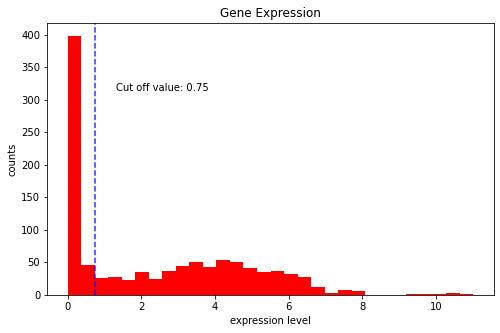

In [49]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.log2(expression["expression"]+1),bins=30, color = "red")
ax.set_ylabel("counts")
ax.set_xlabel("expression level")
ax.set_title("Gene Expression")
ax.axvline(x=0.75, color = 'blue', linestyle = 'dashed', alpha = 0.8)
max_ylim = plt.ylim()[1]
ax.text(1.3,max_ylim*0.75, "Cut off value: 0.75")
plt.show()

Violin Plot

import map data

In [54]:
mapped_comp_df = pd.read_csv("/Users/cmdb/qbb2021-answers/week6/K562_hg19_FPKM_chr3_mapnorm_compartment.bed",sep='\t',names=["chr","start","end","gene","expression","strand","H3K27me3","compartment"])
mapped_comp_df

,chr,start,end,gene,expression,strand,H3K27me3,compartment
0,chr3,238279,451090,CHL1,0.00,+,0.217979,.
1,chr3,1134260,1445901,CNTN6,0.00,+,0.212417,.
2,chr3,2140497,3099645,CNTN4,0.01,+,0.271694,.
3,chr3,3111233,3168297,IL5RA,0.14,-,1.567160,A
4,chr3,3168600,3192563,TRNT1,25.28,+,0.168837,A
...,...,...,...,...,...,...,...,...
1059,chr3,197464050,197514467,FYTTD1,53.14,+,0.170634,A
1060,chr3,197518097,197615307,LRCH3,24.13,+,0.174287,A
1061,chr3,197615946,197687013,IQCG,3.70,-,0.264840,A
1062,chr3,197676858,197683481,RPL35A,1195.67,+,0.173857,A


A compartment

In [57]:
#Expression
A_comp = mapped_comp_df[(np.log2(mapped_comp_df["expression"]+1) >= 1) & (mapped_comp_df["compartment"] == "A")]
A_array = np.asarray(A_comp["H3K27me3"])

#Repression
A_comp2 = mapped_comp_df[(np.log2(mapped_comp_df["expression"]+1) <1) & (mapped_comp_df["compartment"] == "A")] 
A_comp2_array = np.asarray(A_comp2["H3K27me3"])


B compartment

In [58]:
#Expression 
B_comp = mapped_comp_df[(np.log2(mapped_comp_df["expression"]+1) >= 1) & (mapped_comp_df["compartment"] == "B")]
B_array = np.asarray(B_comp["H3K27me3"])

#Repression
B_comp2 = mapped_comp_df[(np.log2(mapped_comp_df["expression"]+1) <1) & (mapped_comp_df["compartment"] == "B")] 
B_comp2_array = np.asarray(B_comp2["H3K27me3"])


Plot violin plot

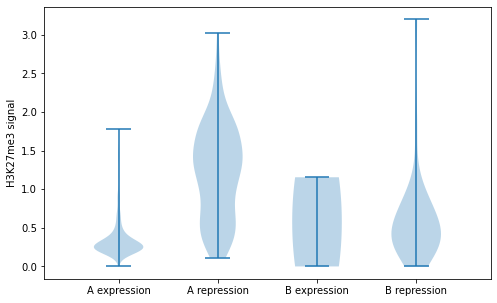

In [79]:
Data = [np.log2(A_array+1),np.log2(A_comp2_array+1),np.log2(B_array+1),np.log2(B_comp2_array+1)]

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)


fig,ax = plt.subplots (figsize = (8,5))
ax.violinplot(Data)
labels=['A expression','A repression','B expression','B repression']
for ax in [ax]:
    set_axis_style(ax,labels)
ax.set_ylabel("H3K27me3 signal")
plt.show()
